## craters_dunes_multilabel
Here I cannot use the image_dataset_from_directory with a neither/ craters/ dunes/ folder structure because it will create three classes and the label vectors will be 3-vectors like [0 1 1]. Instead, I need to try another method

In [192]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.ops import io_ops,image_ops,array_ops,math_ops
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix,
    multilabel_confusion_matrix)

## Generate a dataset

In [48]:
data_fld = '/home/ahoag/ML/mars/craters_dunes/images_for_cnn'

In [246]:
neither_dir = os.path.join(data_fld,'neither')
images_neither = glob.glob(neither_dir+'/*jpg')
basenames_neither = set([x.split('/')[-1] for x in images_neither])
craters_dir = os.path.join(data_fld,'craters')
images_craters = glob.glob(craters_dir+'/*jpg')
basenames_craters = set([x.split('/')[-1] for x in images_craters])
dunes_dir = os.path.join(data_fld,'dunes')
images_dunes = glob.glob(dunes_dir+'/*jpg')
basenames_dunes = set([x.split('/')[-1] for x in images_dunes])
all_unique_basenames = list(basenames_neither.union(basenames_craters).union(basenames_dunes))

In [247]:
def make_labels():
    """ Figure out which images have craters, dunes and neither in them """
    all_image_labels=np.zeros((len(all_unique_basenames),2))
    for ii in range(len(all_unique_basenames)):
        basename = all_unique_basenames[ii]
        if basename in basenames_neither:
            # already zeros in the array so nothing to do
            continue
        else:
            if basename in basenames_craters:
                all_image_labels[ii][0]=1.
            if basename in basenames_dunes:
                all_image_labels[ii][1]=1.
    return all_image_labels

labels = make_labels()

In [248]:
labels.shape

(2219, 2)

In [249]:
# Make sure there are 750 "neither" entries, i.e. where label=[0.,0.]
assert len([x for x in labels if x[0]==0 and x[1]==0]) == 750

In [250]:
len([x for x in labels if x[0]==1 and x[1]==1])

31

In [253]:
[x for x in basenames_craters if x in basenames_dunes]

['ESP_011289_1950_x200-400_y200-400.jpg',
 'ESP_020562_1550_x600-800_y0-200.jpg',
 'ESP_020562_1550_x0-200_y400-600.jpg',
 'ESP_033471_1580_x200-400_y200-400.jpg',
 'PSP_006835_1535_x200-400_y0-200.jpg',
 'ESP_039274_2055_x400-600_y200-400.jpg',
 'PSP_003239_1870_x400-600_y200-400.jpg',
 'PSP_009841_1530_x0-200_y400-600.jpg',
 'ESP_035062_1995_x600-800_y0-200.jpg',
 'ESP_039187_1915_x400-600_y0-200.jpg',
 'ESP_035863_1710_x600-800_y200-400.jpg',
 'ESP_016954_1590_x200-400_y400-600.jpg',
 'ESP_016895_1525_x200-400_y200-400.jpg',
 'ESP_020683_2010_x600-800_y200-400.jpg',
 'ESP_011765_1780_x200-400_y200-400.jpg',
 'ESP_062877_1690_x600-800_y200-400.jpg',
 'ESP_026007_1640_x0-200_y400-600.jpg',
 'ESP_035409_1525_x0-200_y400-600.jpg',
 'ESP_013726_1475_x200-400_y400-600.jpg',
 'ESP_016895_1525_x600-800_y200-400.jpg',
 'PSP_007219_1720_x0-200_y400-600.jpg',
 'ESP_033599_2160_x600-800_y0-200.jpg',
 'ESP_052438_1560_x200-400_y200-400.jpg',
 'ESP_017036_1665_x400-600_y0-200.jpg',
 'PSP_007751_1

In [121]:
def get_fullpath(filename):
    # Given filename find a full path to file
    # in any of the dunes/ craters/ or neither/ 
    # folders
    if filename in basenames_neither:
        return os.path.join(neither_dir,filename)
    elif filename in basenames_craters:
        return os.path.join(craters_dir,filename)
    elif filename in basenames_dunes:
        return os.path.join(dunes_dir,filename)
    else:
        return None

image_size=(180,180)
num_channels=3

def path_to_image(path, image_size, num_channels, interpolation):
    fullpath = get_fullpath(path)
    img = io_ops.read_file(fullpath)
    img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
    img = image_ops.resize_images_v2(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

all_image_data = np.array([path_to_image(x, image_size, num_channels, interpolation='bilinear') for x in all_unique_basenames])

In [122]:
all_image_data.shape

(2219, 180, 180, 3)

## Visualize the data

#[crater, dune]


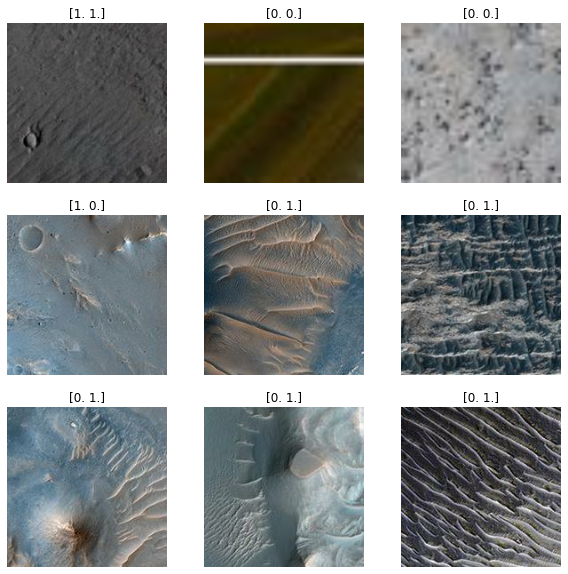

In [131]:
plt.figure(figsize=(10, 10))
print("#[crater, dune]")
rand_indices = np.random.randint(0,len(labels),9)

for ii in range(9):
    rand_index = rand_indices[ii]
    ax = plt.subplot(3, 3, ii + 1)
    plt.imshow(all_image_data[rand_index].astype("uint8"))
#         print()
    plt.title(str(labels[rand_index]))
    plt.axis("off")

## Using image data augmentation

In [132]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

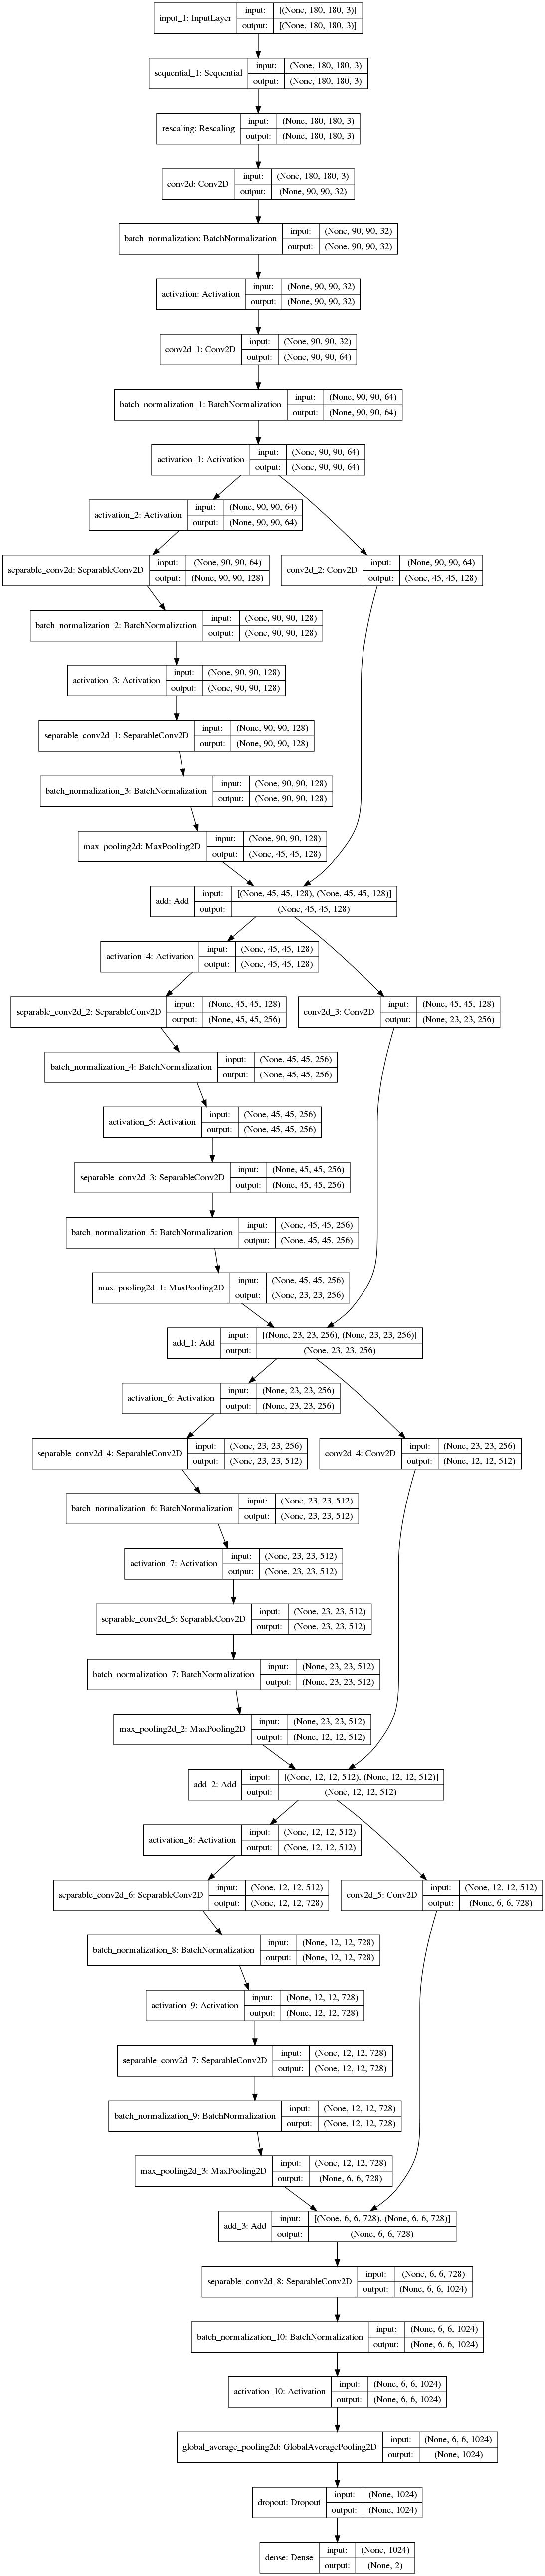

In [134]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [135]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [136]:
X_train, X_val, y_train, y_val = train_test_split(
   all_image_data, labels, test_size=0.2, random_state=42)

In [137]:
X_train.shape

(1775, 180, 180, 3)

In [138]:
X_val.shape

(444, 180, 180, 3)

In [139]:
y_train.shape

(1775, 2)

In [140]:
y_val.shape

(444, 2)

## Train the model

In [141]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/craters_dunes/cnn_saved_epochs/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=X_train,y=y_train, batch_size=32, epochs=epochs, callbacks=callbacks, validation_data=(X_val,y_val),
)

Epoch 1/60
56/56 [==============================] - 81s 1s/step - loss: 0.7123 - accuracy: 0.5420 - val_loss: 0.6384 - val_accuracy: 0.6937
Epoch 2/60
56/56 [==============================] - 79s 1s/step - loss: 0.5065 - accuracy: 0.6586 - val_loss: 0.8914 - val_accuracy: 0.6937
Epoch 3/60
56/56 [==============================] - 81s 1s/step - loss: 0.4122 - accuracy: 0.6515 - val_loss: 1.0988 - val_accuracy: 0.6937
Epoch 4/60
56/56 [==============================] - 86s 2s/step - loss: 0.4491 - accuracy: 0.6743 - val_loss: 1.4331 - val_accuracy: 0.6937
Epoch 5/60
56/56 [==============================] - 88s 2s/step - loss: 0.4059 - accuracy: 0.7150 - val_loss: 1.5807 - val_accuracy: 0.6937
Epoch 6/60
56/56 [==============================] - 90s 2s/step - loss: 0.3882 - accuracy: 0.6589 - val_loss: 1.6578 - val_accuracy: 0.6937
Epoch 7/60
56/56 [==============================] - 85s 2s/step - loss: 0.3861 - accuracy: 0.7252 - val_loss: 1.5743 - val_accuracy: 0.3964
Epoch 8/60
56/56 [==

56/56 [==============================] - 77s 1s/step - loss: 0.1416 - accuracy: 0.8266 - val_loss: 0.2061 - val_accuracy: 0.6014
Epoch 60/60
56/56 [==============================] - 77s 1s/step - loss: 0.1379 - accuracy: 0.8234 - val_loss: 0.1927 - val_accuracy: 0.8198


## Evaluate the model

In [263]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

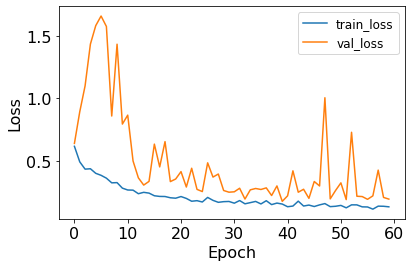

In [265]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right',fontsize=12)
plt.tight_layout()
# plt.savefig('../attempt2/training_attempt2.png')

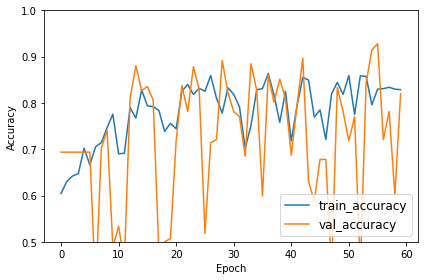

In [142]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()
# plt.savefig('../attempt2/training_attempt2.png')

Accuracy kind of all over the place. Possibly due to small number of training samples, too small batch size or too large a learning rate. It does look like the model is learning though! I attempted a model with smaller learning rate of 1e-4 and it did not really improve this curve. Let's take a look at some predictions

In [237]:
test_fld = '/home/ahoag/ML/mars/craters_dunes/test_cnn'

These all look good! I think this is working! Maybe coincidence so we will want to make a more thorough test set. 

In [146]:
max_val_acc = max(history.history['val_accuracy'])
history.history['val_accuracy'].index(max_val_acc)+1 

56

In [147]:
print(f"Maximum val_accuracy = {max_val_acc}")

Maximum val_accuracy = 0.9279279112815857


In [151]:
best_model_save_file = '/home/ahoag/ML/mars/craters_dunes/cnn_saved_epochs/save_at_56.h5'
best_model = keras.models.load_model(best_model_save_file)

## Evaluate best model (at epoch 56) on test set

In [238]:
# Load test images and labels
neither_dir_test = os.path.join(test_fld,'neither')
images_neither_test = glob.glob(neither_dir_test+'/*jpg')
basenames_neither_test = set([x.split('/')[-1] for x in images_neither_test])
craters_dir_test = os.path.join(test_fld,'craters')
images_craters_test = glob.glob(craters_dir_test+'/*jpg')
basenames_craters_test = set([x.split('/')[-1] for x in images_craters_test])
dunes_dir_test = os.path.join(test_fld,'dunes')
images_dunes_test = glob.glob(dunes_dir_test+'/*jpg')
basenames_dunes_test = set([x.split('/')[-1] for x in images_dunes_test])
all_unique_basenames_test = list(basenames_neither_test.union(basenames_craters_test).union(basenames_dunes_test))

In [239]:
len(all_unique_basenames_test)

461

In [240]:
def make_labels_test():
    """ Figure out which images have craters, dunes and neither in them """
    all_image_labels=np.zeros((len(all_unique_basenames_test),2))
    for ii in range(len(all_unique_basenames_test)):
        basename = all_unique_basenames_test[ii]
        if basename in basenames_neither_test:
            # already zeros in the array so nothing to do
            continue
        else:
            if basename in basenames_craters_test:
                all_image_labels[ii][0]=1.
            if basename in basenames_dunes_test:
                all_image_labels[ii][1]=1.
    return all_image_labels

labels_test = make_labels_test()

In [241]:
labels_test.shape

(461, 2)

In [242]:
def get_fullpath_test(filename):
    # Given filename find a full path to file
    # in any of the dunes/ craters/ or neither/ 
    # folders
    if filename in basenames_neither_test:
        return os.path.join(neither_dir_test,filename)
    elif filename in basenames_craters_test:
        return os.path.join(craters_dir_test,filename)
    elif filename in basenames_dunes_test:
        return os.path.join(dunes_dir_test,filename)
    else:
        return None

image_size=(180,180)
num_channels=3

def path_to_image_test(path, image_size, num_channels, interpolation):
    fullpath = get_fullpath_test(path)
    img = io_ops.read_file(fullpath)
    img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
    img = image_ops.resize_images_v2(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

all_image_data_test = np.array([path_to_image_test(x, image_size, num_channels, interpolation='bilinear') for x in all_unique_basenames_test])

In [164]:
all_image_data_test.shape

(461, 180, 180, 3)

#[crater, dune]


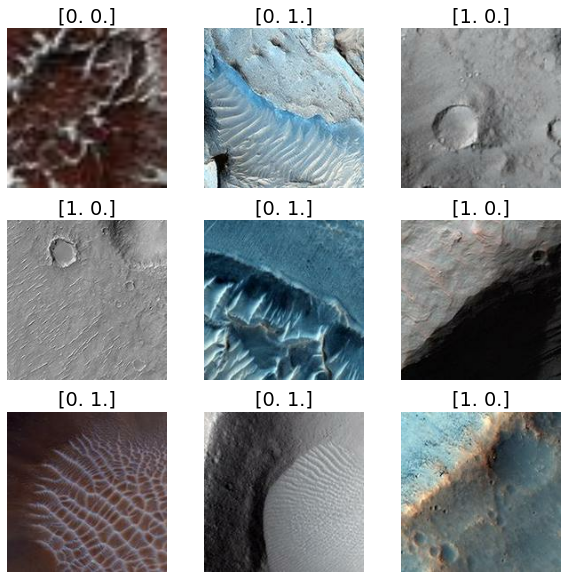

In [256]:
# Plot some test images and labels
plt.figure(figsize=(10, 10))
print("#[crater, dune]")
rand_indices = np.random.randint(0,len(labels_test),9)

for ii in range(9):
    rand_index = rand_indices[ii]
    ax = plt.subplot(3, 3, ii + 1)
    plt.imshow(all_image_data_test[rand_index].astype("uint8"))
    plt.title(str(labels_test[rand_index]))
    plt.axis("off")

In [166]:
X_test = all_image_data_test
y_test = labels_test

In [167]:
# Load in test images and labels

result = best_model.evaluate(x=X_test,y=y_test)

15/15 [==============================] - 4s 279ms/step - loss: 0.2163 - accuracy: 0.9197


Looks like my test-set accuracy is 92%. That's amazing! Let's look at confusion matrix

In [172]:
test_probs=best_model.predict(X_test)

In [184]:
test_pred_bool = test_probs>0.5
test_predictions = test_pred_bool.astype(float)

In [187]:
y_test[0:10]

array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.]])

In [189]:
test_predictions[0:10]

array([[0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.]])

In [257]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          savefig=False):
    """
    This function prints and plots the confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = 'd'
    fmt_norm = '.2f'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt)+f' ({format(cm_norm[i, j], fmt_norm)})',
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    if savefig:
        savename = '../craters_dunes/confusion_matrix_dunes.png'
        plt.savefig(savename)
        print(f"Saved {savename}")

[[292  15]
 [ 21 133]]


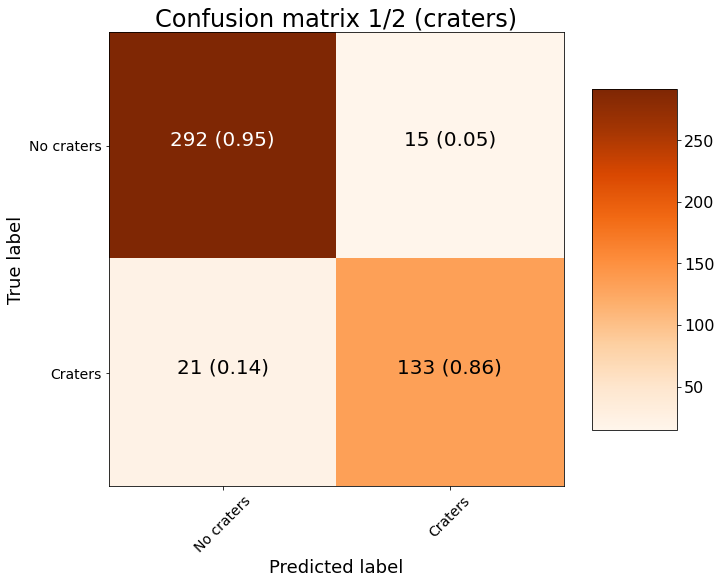

In [258]:
cm = multilabel_confusion_matrix(y_test, test_predictions) # makes a confusion matrix for each label
plot_confusion_matrix(cm[0], classes = ['No craters', 'Craters'],
                      title = 'Confusion matrix 1/2 (craters)',
                     )

[[286  21]
 [ 14 140]]
Saved ../craters_dunes/confusion_matrix_dunes.png


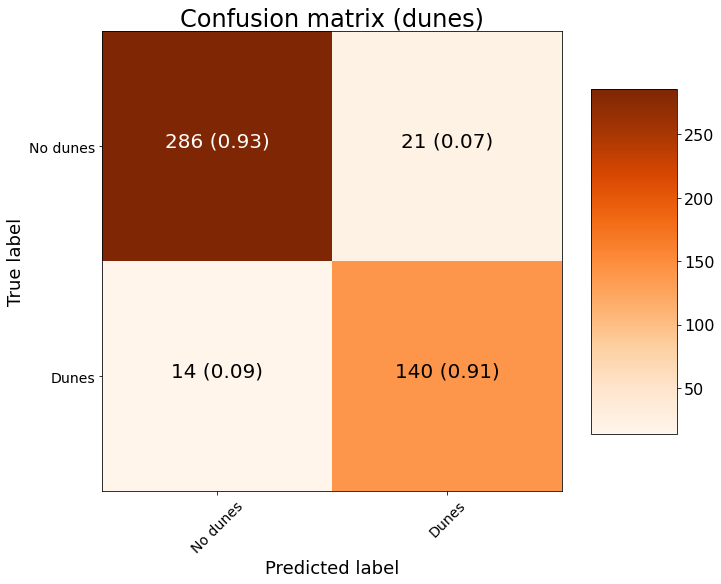

In [259]:
plot_confusion_matrix(cm[1], classes = ['No dunes', 'Dunes'],
                      title = 'Confusion matrix (dunes)',
                      savefig=True,
                     )

This is legitimately working! The model is even better than the single-label model! That is because picking out dunes is apparently easier than picking out craters.

In [194]:
cm

array([[[292,  15],
        [ 21, 133]],

       [[286,  21],
        [ 14, 140]]])

## Plot the two ROC curves

In [228]:
def evaluate_model(predictions, probs,):
    """
    Compare machine learning model to baseline and previous model performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
#     baseline = {}
    
#     baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
#     baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
#     baseline['roc'] = 0.5
    
    results = {}
    
#     results['recall'] = recall_score(y_test, predictions)
#     results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    print(results)
#     for metric in ['recall', 'precision', 'roc']:
#         print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)}'
#               f' Test: {round(results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test[:,0], [1 for _ in range(len(y_test))])
#     prevmodel_fpr, prevmodel_tpr, _ = roc_curve(prevmodel_y_test, prevmodel_probs)
    fig=plt.figure(figsize = (8, 6))
    ax=fig.add_subplot(1,1,1)
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    for class_index in range(y_test.shape[1]):
        model_fpr, model_tpr, _ = roc_curve(y_test[:,class_index], probs[:,class_index])
        if class_index == 0:
            label = 'Xception (craters)'
        else:
            label = 'Xception (dunes)'
        ax.plot(model_fpr, model_tpr, label = label )
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
#     plt.savefig('../attempt2/roc_auc_compare1and2.png')

{'roc': 0.9747028216083591}


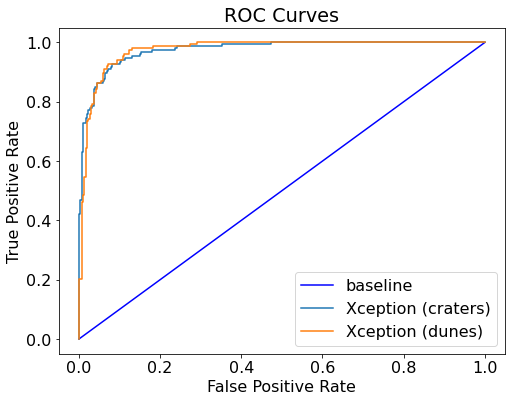

In [229]:
evaluate_model(test_predictions,test_probs)

In [230]:
roc_auc_score(y_test, test_probs)

0.9747028216083591

## Look at some true true positives

In [232]:
true_positives = []
for ii in range(len(X_test)): # loop over batches
    truth = y_test[ii]
    predicted_label = test_predictions[ii]
    if all([predicted_label[jj] == truth[jj] for jj in (0,1)]):
        tp_dict = {'image':X_test[ii],'pred':test_probs[ii]}
        true_positives.append(tp_dict)


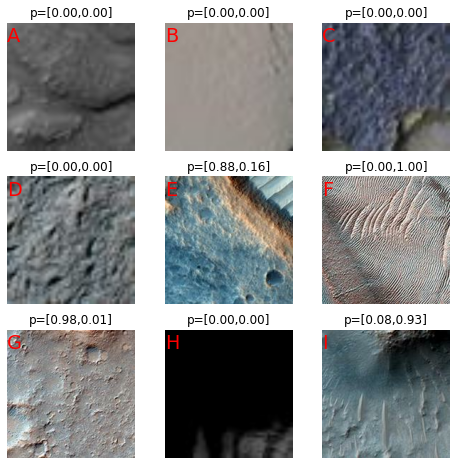

In [235]:
# inspect true positives
# np.random.shuffle(false_negatives)
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].astype("uint8"))
    pred = true_positives[i]['pred']
    pred_crater = pred[0]
    pred_dune = pred[1]
    plt.title(f"p=[{pred_crater:.2f},{pred_dune:.2f}]",fontsize=12)
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='large')

    plt.axis("off")


Model works excellently! I am kind of concerned that there was data leakage! Don't actually think that happened but would want to check.

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [251]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

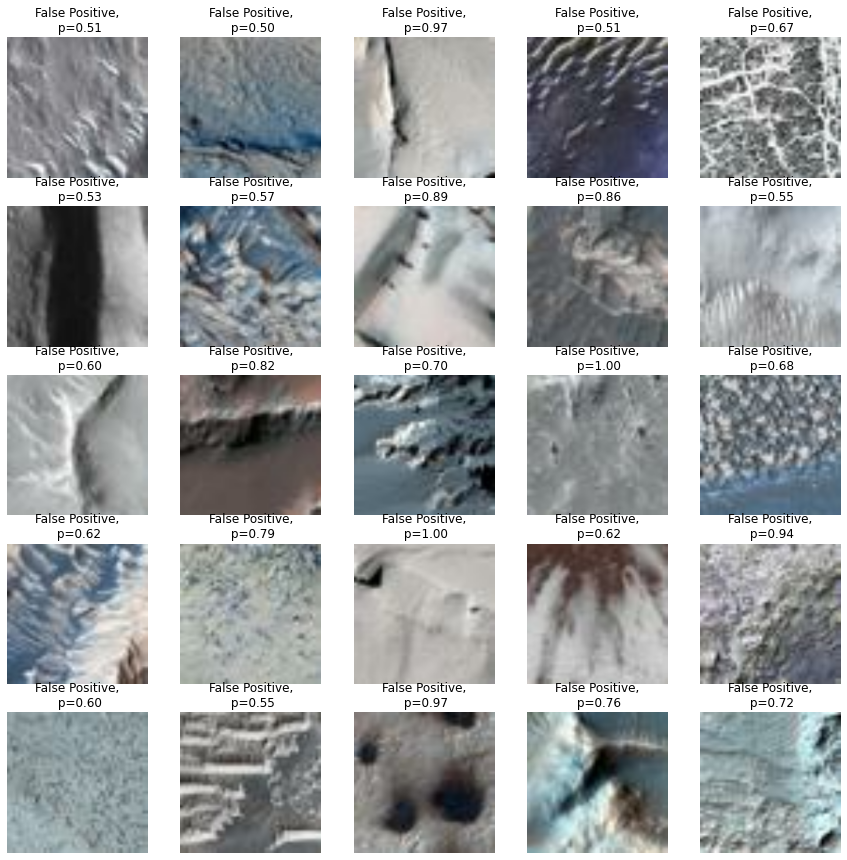

In [252]:
# inspect false positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"False Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

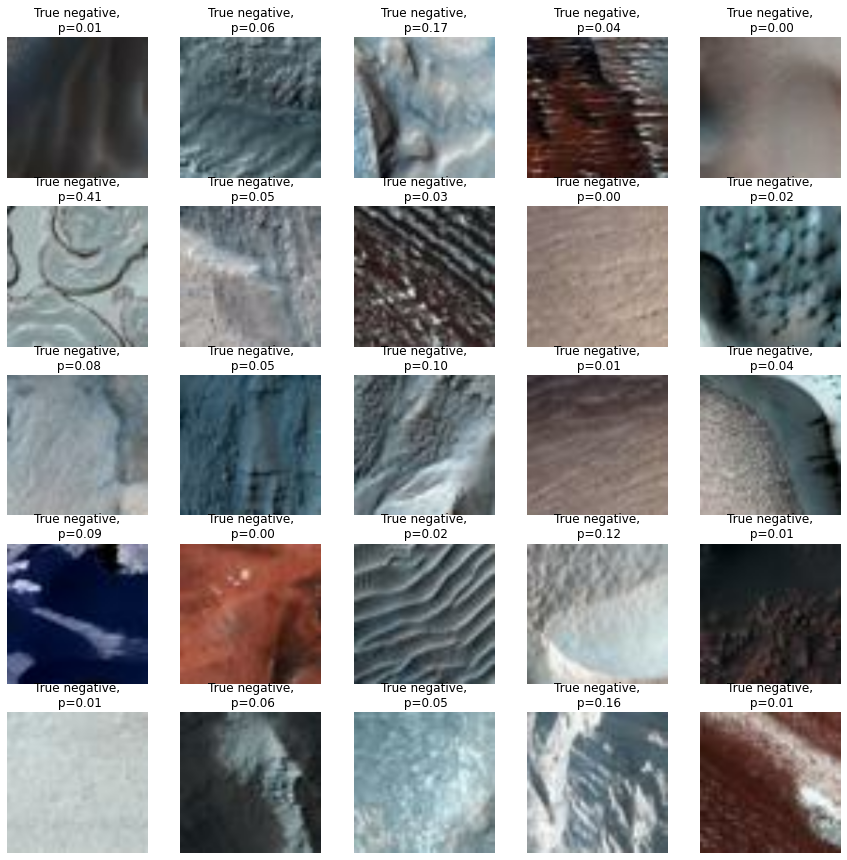

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
